# UCC benchmarks
In this notebook, we benchmark the performance of Unitary Fund's UCC compiler against pytket, TKET and Cirq across a range of benchmarks (100 qubits each): 

- Quantum Approximate Optimization Algorithm (QAOA)
- Quantum Fourier transform (QFT)
- Square Heisenberg model Trotterized Hamiltonian simulation
- Quantum computational neural network (QCNN)
- Quantum volume  (QV) calculation
- PREPARE & SELECT on a GHZ state
- Parameterized circuit Variational Quantum Eigensolver (VQE)

#### Circuit definitions
For the **QAOA, QFT, Square Heisenberg,** and **QV** circuits, we copy the corresponding [OpenQASM 2 code](https://github.com/pytket/benchpress/tree/main/benchpress/qasm) from pytket's benchpress library. For the QCNN and Prepare & Select circuits, we generate QASM 2 code using our own implementations in pytket. 


#### Transpilation
For all benchmarks, we then use qbraid's [transpile](https://docs.qbraid.com/sdk/user-guide/transpiler) function to translate into the native format each SDK's compiler. 

**Note**: `qbraid.transpile` does NOT perform any circuit optimization; it only translates between circuit representations. 

#### Compilation
We then run a compiler pass on the raw circuit for each SDK, as defined below. Since there is not a default set of compiler passes for `Cirq` or `PyTKET`, we chose a subset of those available. We invite anyone more familiar with these compiler libraries to suggest more optimal passes. 

However, it is worth pointing out that a major goal of UCC is to simplify the process of compilation for quantum developers and provide a "good default" set of passes which is relatively quick and on par or better than other state of the art compilers.

In [1]:
folder = "./circuits/qasm2/"

qasm_files = [folder + file for file in [
    "benchpress/qaoa_barabasi_albert_N100_3reps.qasm", # Is this one already optimal?
    "benchpress/qft_N100.qasm",
    "benchpress/qv_N100_12345.qasm",
    "benchpress/square_heisenberg_N100.qasm",
    "ucc/prep_select100_ghz.qasm",
    "ucc/qcnn_N100_7layers.qasm"
    ]]

In [2]:
from qiskit import transpile as qiskit_transpile

def qiskit_compile(qiskit_circuit):
    """Compile given qiskit.QuantumCircuit object and return the compiled circuit and total number of raw and compiled 2 qubit gates"""
    raw_gates = qiskit_circuit.count_ops()
    num_raw_gates = raw_gates.get("cz", 0) + raw_gates.get("cx", 0)

    compiled_circuit = qiskit_transpile(qiskit_circuit, optimization_level=3)
    compiled_gates = compiled_circuit.count_ops()
    num_compiled_gates = compiled_gates.get("cz", 0) + compiled_gates.get("cx", 0)
    
    return compiled_circuit, num_raw_gates, num_compiled_gates

In [3]:
from cirq.transformers import optimize_for_target_gateset, CZTargetGateset


def cirq_compile(cirq_circuit):
    """Compile given cirq.Circuit object and return the compiled circuit and total number of raw and compiled 2 qubit gates"""
    num_raw_gates = sum(
        1 for op in cirq_circuit.all_operations() if len(op.qubits) == 2)

    # Assuming `cirq_circuit` is your Cirq circuit
    compiled_circuit = optimize_for_target_gateset(
    cirq_circuit, 
    gateset=CZTargetGateset()
    )


    # Total 2-qubit gates in compiled Cirq circuit
    num_compiled_gates = sum(
        1 for op in compiled_circuit.all_operations() if len(op.qubits) == 2)

    return compiled_circuit, num_raw_gates, num_compiled_gates


In [4]:
# Compile using TKET
from pytket.passes import FullPeepholeOptimise
from pytket.predicates import CompilationUnit

def pytket_compile(pytket_circuit):
    """Compile given pytket.Circuit object and return the compiled circuit and total number of raw and compiled 2 qubit gates"""
    num_raw_gates = pytket_circuit.n_2qb_gates()

    compilation_unit = CompilationUnit(pytket_circuit)
    FullPeepholeOptimise().apply(compilation_unit)
    compiled_circuit = compilation_unit.circuit
    num_compiled_gates = compiled_circuit.n_2qb_gates()

    # # Total 2-qubit gates in tket circuit
    # num_2q_ops = sum(
    #     1 for command in compiled_circuit if len(command.qubits) == 2)

    return compiled_circuit, num_raw_gates, num_compiled_gates


In [5]:
from ucc import compile 

def ucc_compile(circuit):
    """Compile given qiskit.QuantumCircuit and return the compiled circuit and total number of raw and compiled 2 qubit gates"""
    raw_gates = circuit.count_ops()
    num_raw_gates = raw_gates.get("cz", 0) + raw_gates.get("cx", 0)

    compiled_circuit, compiled_gates = compile(circuit, get_gate_counts=True)
    num_compiled_gates = compiled_gates.get("cz", 0) + compiled_gates.get("cx", 0)

    return compiled_circuit, num_raw_gates, num_compiled_gates

In [6]:
from time import time

def log_performance(compiler_function, circuit):
    t1 = time()
    compiled_circuit, num_raw_gates, num_compiled_gates = compiler_function(circuit)
    t2 = time()
    
    log = {"compile_time": t2 - t1}
    log["raw_gates"] = num_raw_gates
    log["compiled_gates"] = num_compiled_gates
    # Should also log the compiler software version
    
    return compiled_circuit, log

In [16]:
from qbraid.transpiler import transpile as translate

compiler_specs = [
    ('ucc', ucc_compile), 
    ('pytket', pytket_compile),
    ('qiskit', qiskit_compile),
    ('cirq', cirq_compile)
]
results_log = []
for filename in qasm_files:
    # Open the QASM file and read its content into a string
    with open(filename, "r") as file:
        qasm_string = file.read()
        for alias, compile_func in compiler_specs:
            if alias == 'ucc':
                # Qiskit used for UCC to get raw gate counts
                native_circuit = translate(qasm_string, 'qiskit')
            else:
                native_circuit = translate(qasm_string, alias) 
            compiled, log_entry = log_performance(compile_func, native_circuit)
            log_entry['compiler'] = alias
            log_entry['circuit_name'] = filename.split('/')[-1]
            print(log_entry)
            results_log.append(log_entry)
            

{'compile_time': 0.14574885368347168, 'raw_gates': 1176, 'compiled_gates': 1176, 'compiler': 'ucc', 'circuit_name': 'qaoa_barabasi_albert_N100_3reps.qasm'}
{'compile_time': 30.77385425567627, 'raw_gates': 1176, 'compiled_gates': 1176, 'compiler': 'pytket', 'circuit_name': 'qaoa_barabasi_albert_N100_3reps.qasm'}
{'compile_time': 0.46051812171936035, 'raw_gates': 1176, 'compiled_gates': 1176, 'compiler': 'qiskit', 'circuit_name': 'qaoa_barabasi_albert_N100_3reps.qasm'}
{'compile_time': 4.93453311920166, 'raw_gates': 1176, 'compiled_gates': 1176, 'compiler': 'cirq', 'circuit_name': 'qaoa_barabasi_albert_N100_3reps.qasm'}
{'compile_time': 1.0234050750732422, 'raw_gates': 10050, 'compiled_gates': 4648, 'compiler': 'ucc', 'circuit_name': 'qft_N100.qasm'}
{'compile_time': 148.51429390907288, 'raw_gates': 10050, 'compiled_gates': 4498, 'compiler': 'pytket', 'circuit_name': 'qft_N100.qasm'}
{'compile_time': 21.370937824249268, 'raw_gates': 10050, 'compiled_gates': 3244, 'compiler': 'qiskit', 'c

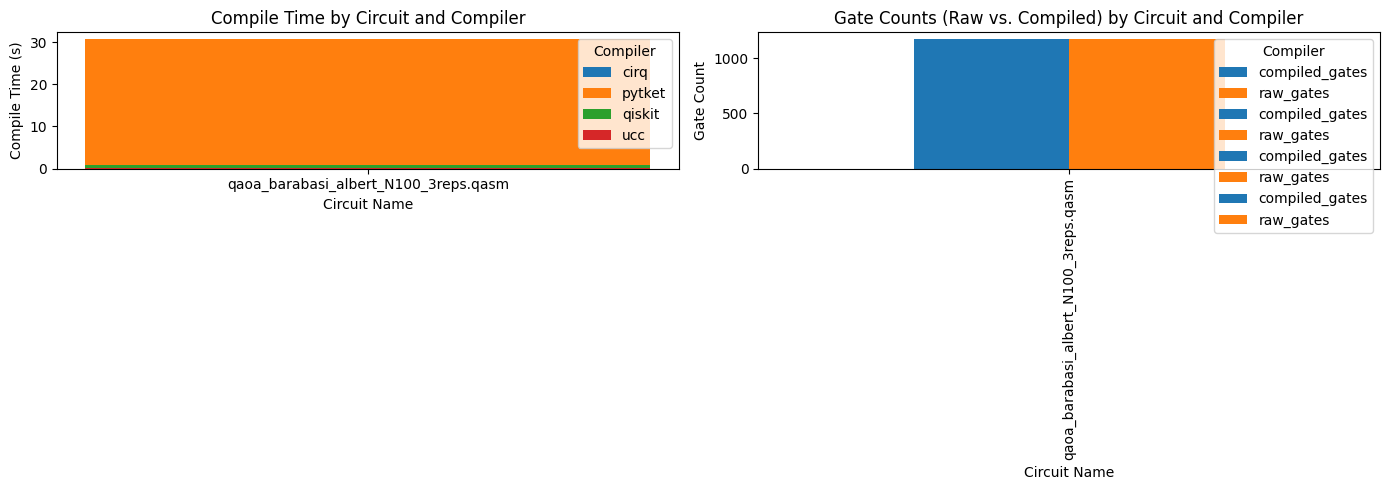

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert results_log to a DataFrame
df = pd.DataFrame(results_log)

# Plot 1: Compile Time by Circuit and Compiler
fig, ax = plt.subplots(1, 2, figsize=(14, 5))  # Create a 1x2 subplot grid

# Barplot for compile times
for key, grp in df.groupby("compiler"):
    ax[0].bar(grp["circuit_name"], grp["compile_time"], label=key)
ax[0].set_title("Compile Time by Circuit and Compiler")
ax[0].set_xlabel("Circuit Name")
ax[0].set_ylabel("Compile Time (s)")
ax[0].legend(title="Compiler")

# Plot 2: Raw vs Compiled Gate Counts by Circuit and Compiler
# Create side-by-side bars for raw vs. compiled gates for each circuit and compiler combination
df_melted = pd.melt(df, id_vars=["circuit_name", "compiler"], value_vars=["raw_gates", "compiled_gates"],
                    var_name="Gate Type", value_name="Gate Count")
for key, grp in df_melted.groupby("compiler"):
    grp.pivot(index="circuit_name", columns="Gate Type", values="Gate Count").plot(kind='bar', ax=ax[1], label=key)

ax[1].set_title("Gate Counts (Raw vs. Compiled) by Circuit and Compiler")
ax[1].set_xlabel("Circuit Name")
ax[1].set_ylabel("Gate Count")
ax[1].legend(title="Compiler")

# Show plot
plt.tight_layout()
plt.show()


In [9]:
import json
# Save results to a JSON file. TODO: make this more infomrative e.g. with version info and system configuration
with open("results_log.json", "w") as json_file:
    json.dump(results_log, json_file, indent=4)


In [10]:
little_df = pd.DataFrame(results_log)
little_df

,compile_time,raw_gates,compiled_gates,compiler,circuit_name
0,0.142008,1176,1176,ucc,qaoa_barabasi_albert_N100_3reps.qasm
1,30.800215,1176,1176,pytket,qaoa_barabasi_albert_N100_3reps.qasm
2,0.944010,1176,1176,qiskit,qaoa_barabasi_albert_N100_3reps.qasm
3,5.306254,1176,1176,cirq,qaoa_barabasi_albert_N100_3reps.qasm


***A note on terminology***

There is some disagreement in the quantum computing community on the proper usage of the terms "transpilation" and "compilation." For instance, Qiskit refers to optimization of the Directed Acyclic Graph (DAG) of a circuit as "transpilation," whereas in qBraid, the 1:1 translation of one circuit representation into another (e.g. a Cirq circuit to a Qiskit circuit; OpenQASM 2 into PyTKET) without optimization is called "transpilation." Cirq on the other hand appears to use the terminology of "transformers" to refer to what Qiskit calls transpiler passes, which PyTKET appears to call CompilationUnits. 

This cornucopia of intersecting definitions does mean that this notebook necessarily mixes terminology. We feel relatively confident we've interpreted these objects and operations accurately across the SDKs we test, but if you find a mistake, please create an issue and let us know!

Within the UCC library, we refer to **transpilation** in the same sense as Qiskit: optimizing the DAG of a circuit in a fixed representation. We then use **compilation** to refer to the whole process, including translation from one circuit representation to another (e.g. OpenQASM 2 to Qiskit), plus DAG optimization (e.g. reducing the number of gates), but we also leave it open-ended to include additional stages in the future, like dynamic compilation based on mid-circuit measurements, quantum error mitigation, and even quantum error correction. [probably needs a diagram]